# Quantum resource estimation with time or number of qubits constraints.

In this Q# notebook we demonstrate resource estimation with time or 
the number of physical qubits constraints. We would use a quantum dynamics 
problem as a sample, more specifically the simulation of an Ising model Hamiltonian on an $N \times N$ 2D
lattice using a *fourth-order Trotter Suzuki product formula* assuming a 2D
qubit architecture with nearest-neighbor connectivity. A detailed sample describing this model is available 
at the [Quantum dynamics resource estimation](https://github.com/microsoft/Quantum/blob/main/samples/azure-quantum/resource-estimation/estimation-dynamics.ipynb) sample. 


First, we connect to the Azure quantum service and load the necessary packages.

In [71]:
from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator, QubitParams, QECScheme
import qsharp

In [72]:
#Enter your Azure Quantum workspace details here
workspace = Workspace(
    resource_id="",
    location=""
)

In [73]:
qsharp.packages.add("Microsoft.Quantum.Numerics")

Adding package Microsoft.Quantum.Numerics.

## Implementation

Here we just put together the implementation of the Ising model provided at [Quantum dynamics resource estimation](https://github.com/microsoft/Quantum/blob/main/samples/azure-quantum/resource-estimation/estimation-dynamics.ipynb).

In [74]:
%%qsharp
open Microsoft.Quantum.Math;

function GetQubitIndex(row : Int, col : Int, n : Int) : Int {
    return row % 2 == 0             // if row is even,
        ? col + n * row             // move from left to right,
        | (n - 1 - col) + n * row;  // otherwise from right to left.
}

function SetSequences(len : Int, p : Double, dt : Double, J : Double, g : Double) : (Double[], Double[]) {
    // create two arrays of size `len`
    mutable seqA = [0.0, size=len];
    mutable seqB = [0.0, size=len];

    // pre-compute values according to exponents
    let values = [
        -J * p * dt,
        g * p * dt,
        -J * p * dt,
        g * p * dt,
        -J * (1.0 - 3.0 * p) * dt / 2.0,
        g * (1.0 - 4.0 * p) * dt,
        -J * (1.0 - 3.0 * p) * dt / 2.0,
        g * p * dt,
        -J * p * dt,
        g * p * dt
    ];

    // assign first and last value of `seqA`
    set seqA w/= 0 <- -J * p * dt / 2.0;
    set seqA w/= len - 1 <- -J * p * dt / 2.0;

    // assign other values to `seqA` or `seqB`
    // in an alternating way
    for i in 1..len - 2 {
        if i % 2 == 0 {
            set seqA w/= i <- values[i % 10];
        }
        else {
            set seqB w/= i <- values[i % 10];
        }
    }

    return (seqA, seqB);
}

operation ApplyAllX(qs : Qubit[], theta : Double) : Unit {
    // This applies `Rx` with an angle of `2.0 * theta` to all qubits in `qs`
    // using partial application
    ApplyToEach(Rx(2.0 * theta, _), qs);
}

operation ApplyDoubleZ(n : Int, qs : Qubit[], theta : Double, dir : Bool, grp : Bool) : Unit {
    let start = grp ? 0 | 1;    // Choose either odd or even indices based on group number

    for i in 0..n - 1 {
        for j in start..2..n - 2 {    // Iterate through even or odd `j`s based on `grp`
            // rows and cols are interchanged depending on direction
            let (row, col) = dir ? (i, j) | (j, i);

            // Choose first qubit based on row and col
            let ind1 = GetQubitIndex(row, col, n);
            // Choose second qubit in column if direction is horizontal and next qubit in row if direction is vertical
            let ind2 = dir ? GetQubitIndex(row, col + 1, n) | GetQubitIndex(row + 1, col, n);

            within {
                CNOT(qs[ind1], qs[ind2]);
            } apply {
                Rz(2.0 * theta, qs[ind2]);
            }
        }
    }
}

operation IsingModel2DSim(N : Int, J : Double, g : Double, totTime : Double, dt : Double, eps : Double) : Unit {
    use qs = Qubit[N * N];
    let len = Length(qs);

    let p = 1.0 / (4.0 - PowD(4.0, 1.0 / 3.0));
    let t = Ceiling(totTime / dt);

    let seqLen = 10 * t + 1;

    let (seqA, seqB) = SetSequences(seqLen, p, dt, J, g);

    for i in 0..seqLen - 1 {
        // for even indexes
        if i % 2 == 0 {
            ApplyAllX(qs, seqA[i]);
        } else {
            // iterate through all possible combinations for `dir` and `grp`.
            for (dir, grp) in [(true, true), (true, false), (false, true), (false, false)] {
                ApplyDoubleZ(N, qs, seqB[i], dir, grp);
            }
        }
    }
}

## Running the experiment

Next, we are estimating the physical resource estimates to simulate the Ising
model Hamiltonian for a $10 \times 10$ lattice with $J = g = 1.0$, total time
$20$, step size $0.25$, and `eps` ${}=0.001$. As configurations for the
experiment we use all six pre-defined qubit parameters.  As pre-defined QEC
scheme we are using `surface_code` with gate-based qubit parameters (default),
and `floquet_code` with Majorana based qubit parameters.

In [75]:
estimator = MicrosoftEstimator(workspace)

labels = ["Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴", "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴", "Majorana ns, 10⁻⁴", "Majorana ns, 10⁻⁶"]

params = estimator.make_params(num_items=6)
params.arguments["N"] = 10
params.arguments["J"] = 1.0
params.arguments["g"] = 1.0
params.arguments["totTime"] = 20.0
params.arguments["dt"] = 0.25
params.arguments["eps"] = 0.001
params.items[0].qubit_params.name = QubitParams.GATE_US_E3
params.items[1].qubit_params.name = QubitParams.GATE_US_E4
params.items[2].qubit_params.name = QubitParams.GATE_NS_E3
params.items[3].qubit_params.name = QubitParams.GATE_NS_E4
params.items[4].qubit_params.name = QubitParams.MAJ_NS_E4
params.items[4].qec_scheme.name = QECScheme.FLOQUET_CODE
params.items[5].qubit_params.name = QubitParams.MAJ_NS_E6
params.items[5].qec_scheme.name = QECScheme.FLOQUET_CODE

We are submitting a resource estimation job with all target parameter configurations.

In [76]:
job = estimator.submit(IsingModel2DSim, input_params=params)
job.wait_until_completed(timeout_secs=300)
results = job.get_results()

.......

## Visualizing and understanding the results

### Result summary table

In [77]:
results.summary_data_frame(labels=labels)

,Logical qubits,Logical depth,T states,Code distance,T factories,T factory fraction,Physical qubits,rQOPS,Physical runtime
"Gate-based µs, 10⁻³",230,154.12k,2.35M,19,199,94.54 %,3.04M,20.18k,29 mins
"Gate-based µs, 10⁻⁴",230,154.12k,2.35M,9,199,94.54 %,682.02k,42.59k,14 mins
"Gate-based ns, 10⁻³",230,154.12k,2.35M,19,242,97.98 %,8.23M,30.26M,1 secs
"Gate-based ns, 10⁻⁴",230,154.12k,2.35M,9,199,94.54 %,682.02k,63.89M,555 millisecs
"Majorana ns, 10⁻⁴",230,154.12k,2.35M,9,260,98.45 %,5.77M,85.19M,416 millisecs
"Majorana ns, 10⁻⁶",230,154.12k,2.35M,5,224,95.12 %,621.72k,153.33M,231 millisecs


Let us define a method for drawing charts. Now we have a single point (shot) per physical qubit type. Below, we will make multiple experiments per physical qubit type varying constraints to balance a tradeoff between the number of qubits and the runtime.

In [78]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(results, labels, num_shots, title):
    plt.figure(figsize=(10, 6))

    x = []
    y = []
    label_values = []

    for i in range(len(results.data())):
        r = results.data()[i]
        if 'physicalCounts' in r and 'runtime' in r['physicalCounts'] and 'physicalQubits' in r['physicalCounts']:
            x.append(r['physicalCounts']['runtime'])
            y.append(r['physicalCounts']['physicalQubits'])
            label_values.append(labels[i // num_shots])

    for i, label in enumerate(labels):
        mask = [l == label for l in label_values]
        plt.scatter(np.array(x)[mask], np.array(y)[mask], label=label,s=7)

    plt.xscale('log')
    plt.yscale('log')

    x_min = np.min(x) / 2
    x_max = np.max(x) * 2
    plt.xlim([x_min, x_max])

    y_min = np.min(y) / 2
    y_max = np.max(y) * 2
    plt.ylim([y_min, y_max])

    # for shorter or longer algorithms, it would be worth to modify the xticks
    plt.xticks([1e9, 6e10, 3.6e12, 8.64e13, 6.048e14], ['1 sec', '1 min', '1 hour', '1 day', '1 week'])

    plt.xlabel('Time')
    plt.ylabel('Number of qubits')
    plt.title(title)

    plt.legend()
    plt.show()

Draw result corresponding to shortest runtime possible for each type of qubits.

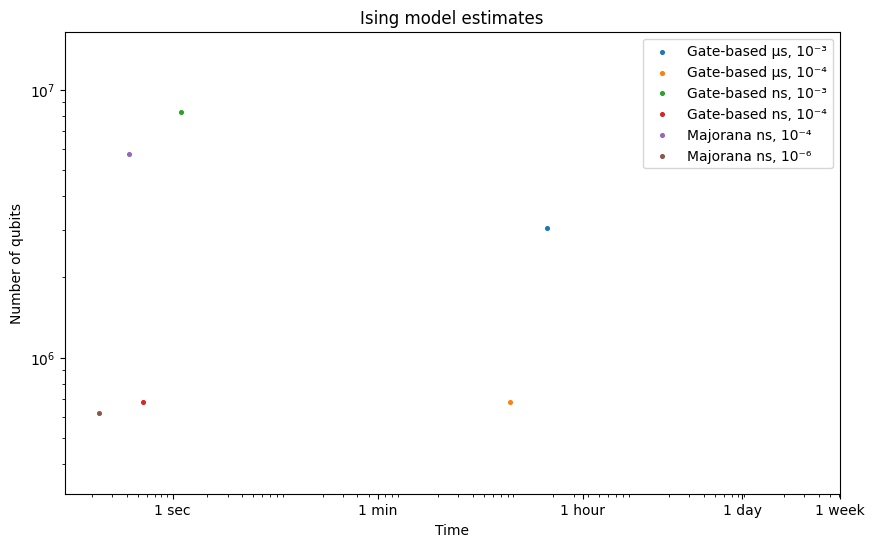

In [79]:
plot_results(results, labels, 1, 'Ising model estimates')

Let us save params, durations and numbers of qubits for future references.

In [82]:
single_shot_params = params
single_shot_x = [r['physicalCounts']['runtime'] for r in results.data()]
single_shot_y = [r['physicalCounts']['physicalQubits'] for r in results.data()]

In [ ]:
multiplier = 1.1
num_shots = 100

params = estimator.make_params(num_items=6 * num_shots)

params.arguments = single_shot_params.arguments

for param_index in range(6):
    max_duration = single_shot_x[param_index]
    for shot_index in range(num_shots):   
        i = param_index * num_shots + shot_index
        params.items[i].constraints.max_duration = f"{max_duration}ns"
        params.items[i].qubit_params.name = single_shot_params.items[param_index].qubit_params.name
        params.items[i].qec_scheme.name = single_shot_params.items[param_index].qec_scheme.name
        max_duration *= multiplier

job = estimator.submit(IsingModel2DSim, input_params=params)
job.wait_until_completed(timeout_secs=300)
results_duration = job.get_results()

..........

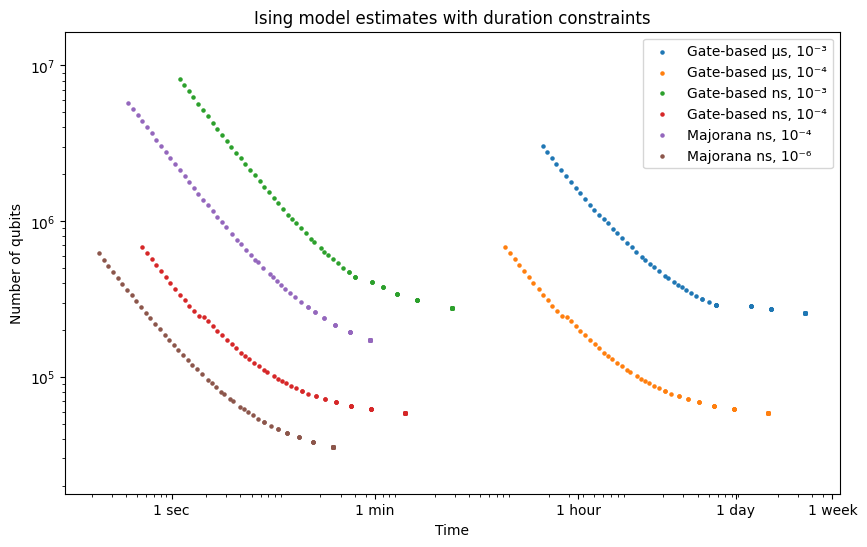

In [ ]:
plot_results(results_duration, labels, num_shots, 'Ising model estimates with duration constraints')

In [ ]:
multiplier = 1.05
num_shots = 100

params = estimator.make_params(num_items=6 * num_shots)

params.arguments = single_shot_params.arguments

for param_index in range(6):
    max_physical_qubits = single_shot_y[param_index]
    for shot_index in range(num_shots):   
        i = param_index * num_shots + shot_index
        params.items[i].constraints.max_physical_qubits = int(max_physical_qubits)
        params.items[i].qubit_params.name = single_shot_params.items[param_index].qubit_params.name
        params.items[i].qec_scheme.name = single_shot_params.items[param_index].qec_scheme.name
        max_physical_qubits /= multiplier

job = estimator.submit(IsingModel2DSim, input_params=params)
job.wait_until_completed(timeout_secs=300)

results_qubits = job.get_results()

.........

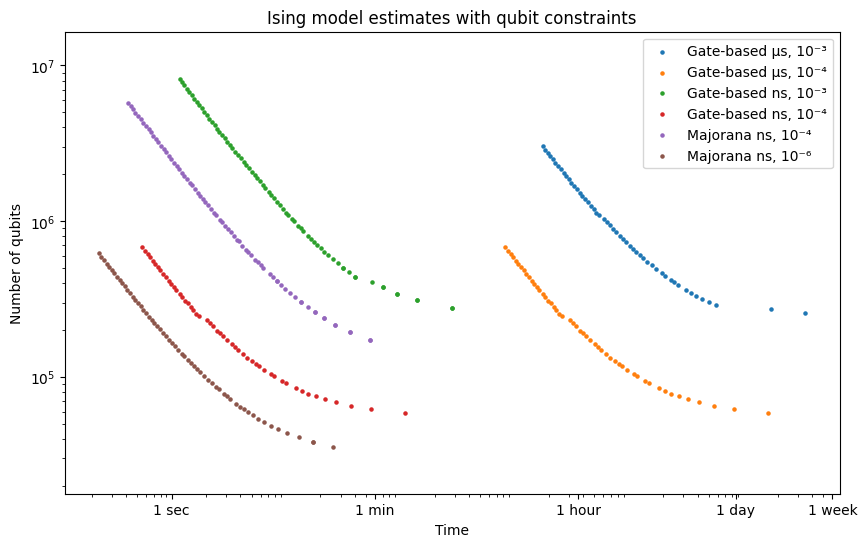

In [62]:
plot_results(results_qubits, labels, num_shots, 'Ising model estimates with qubit constraints')

## Next steps

The numbers in the table match the numbers in the paper [Assessing requirements
for scaling quantum computers to real-world impact](https://aka.ms/AQ/RE/Paper).
Feel free to use this table as a starting point for your own experiments.  For
example, you can

* explore how the results change by modifying the operation arguments of the Ising
  model instance
* explore space- and time-trade-offs by changing the value for
  `logical_depth_factor`
* Visualize these trade-offs with the space and time diagrams
* use other or customized qubit parameters